# Non-Unitary Operators for the Non-Hermitian Skin Effect

Paper to be replicated: https://arxiv.org/pdf/2311.10143

Addition Resources Consulted:
- https://link.aps.org/pdf/10.1103/PRXQuantum.2.010342
- https://medium.com/mdr-inc/time-evolution-operators-be2968493b86 (note there are some notable errors)
- 

In [243]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt
from qiskit.transpiler import CouplingMap
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.circuit.library import UnitaryGate
from qiskit.quantum_info import Statevector

from tqdm.notebook import tqdm

from numpy import sin, cos
import numpy as np
from scipy.linalg import expm, sqrtm

from itertools import product

import random

import json



In [3]:
# service = QiskitRuntimeService()
BACKEND = AerSimulator()
pass_manager = generate_preset_pass_manager(backend=BACKEND, optimization_level=0)
estimator = Estimator(backend=BACKEND)
sampler = Sampler(backend=BACKEND)

## I. Hatano-Nelson Model

Note $\hat{X}^+ = \frac{\hat{X} + i \hat{Y}}{2}$ and $\hat{X}^- = \frac{\hat{X} - i \hat{Y}}{2}$

In [4]:
X_gate = np.array([[0, 1], 
                   [1, 0]])

Y_gate = np.array([[0, -1j],
                   [1j, 0]])

I_gate = np.array([[1, 0], 
                   [0, 1]])

X_plus = 0.5 * (X_gate + 1j * Y_gate)
X_minus = 0.5 * (X_gate - 1j * Y_gate)

In [5]:
print(X_minus)


[[0.+0.j 0.+0.j]
 [1.+0.j 0.+0.j]]


In [62]:
np.concatenate((np.concatenate((X_gate, Y_gate), axis=0), np.concatenate((I_gate, I_gate), axis=0)), axis=1)
    

array([[ 0.+0.j,  1.+0.j,  1.+0.j,  0.+0.j],
       [ 1.+0.j,  0.+0.j,  0.+0.j,  1.+0.j],
       [ 0.+0.j, -0.-1.j,  1.+0.j,  0.+0.j],
       [ 0.+1.j,  0.+0.j,  0.+0.j,  1.+0.j]])

In [224]:
# Helper function, generates U_j_nonH
def get_U_j_nonH(J, gamma, index, N, timestep):
    product_1 = np.kron(X_plus, X_minus)
    product_2 = np.kron(X_minus, X_plus)
    exponent = 1j * timestep * ( (J - gamma) * product_1 + (J + gamma) * product_2)
    
    if index == 0:
        U_j_nonH = np.kron(np.eye(2 ** (N-2)), expm(exponent))
    if index == N - 2:
        U_j_nonH = np.kron(expm(exponent), np.eye(2 ** (N-2)))
    else: 
        U_j_nonH = np.kron(np.kron(np.eye(2 ** (N - 2 - index)), expm(exponent)), np.eye(2 ** (index)))
    return U_j_nonH
    


# Helper function, generates R_HN
def get_R_HN(J, gamma, N, timestep):
    res_even = np.eye(2 ** N)
    res_odd = np.eye(2 ** N)
    for i in range(N - 1):
        if i % 2 == 0:
            res_even = np.matmul(res_even, get_U_j_nonH(J, gamma, i, N, timestep))
        else:
            res_odd = np.matmul(res_odd, get_U_j_nonH(J, gamma, i, N, timestep))
    return np.matmul(res_even, res_odd)

# Generates U_HN 
def get_U_HN(J, gamma, N, timestep):
    R_HN = get_R_HN(J, gamma, N, timestep)

    A, sig, Bh = np.linalg.svd(R_HN)
    eigval, _ = np.linalg.eig(np.matmul(R_HN.conj().T, R_HN))
    u_square_inverse = max(eigval)
    u_square = 1/u_square_inverse 
    C = np.matmul(np.matmul(A, sqrtm(np.eye(2 ** N) - u_square * np.diag(np.square(sig)))), Bh)

    u_R_HN = np.sqrt(u_square) * R_HN
    W = np.concatenate((np.concatenate((u_R_HN, C), axis=0), np.concatenate((np.eye(2 ** N), np.eye(2 ** N)), axis=0)), axis=1)
    U_HN, _ = np.linalg.qr(W)
    return U_HN

In [225]:
# Creates the relevant observable (N here generally includes the auxiliary)
def magnetization_ops(qubit, N):
    observable = SparsePauliOp.from_sparse_list(
    [("Z", [qubit], 0.5), ("I", [qubit], 0.5)], num_qubits=N
    )
    return observable

In [226]:
total_time = 1.8
nb_timesteps = 10
timestep_duration = total_time/nb_timesteps

In [227]:
# For gamma = 0.0 case
N = 6

# Generate the unitary
matrix = get_U_HN(2, 0.0, N, 0.1)
gate = UnitaryGate(matrix)

# Create the relevant circuits for paper's Fig 3a
circuits = []
for n_steps in range(1, nb_timesteps+1):
    qc = QuantumCircuit(N+1)
    qc.h(N//2 - 1)
    qc.cx(N//2 - 1, N//2)
    qc.x(range(N//2-1))
    qc.x(range(N//2+1, N))
    
    gate = UnitaryGate(np.linalg.matrix_power(matrix, n_steps))
    qc.append(gate, [i for i in range(N+1)])
    
    qc.measure_all()
    circuits.append(qc)

# Execute measurements for paper's Fig 3a
magnetization=[]
res_list = []
for circ in tqdm(circuits):
    pubs = [(circ)]
    job = sampler.run(pubs, shots=160000)
    results = job.result()
    res = results[0].data.meas.get_counts()

    counts_left = 0
    row = [0 for _ in range(N)]
    for key, value in res.items():
        if key[0] == "0":
            counts_left += value

            for i in range(1, N+1):
                if key[i] == '0':
                    row[i-1] += value
    magnetization.append([x/counts_left for x in row][::-1]) #the output for qiskit is qNqN-1...q1q0

magnetization=np.array(magnetization)



  0%|          | 0/10 [00:00<?, ?it/s]

Text(0.5, 0, 'T')

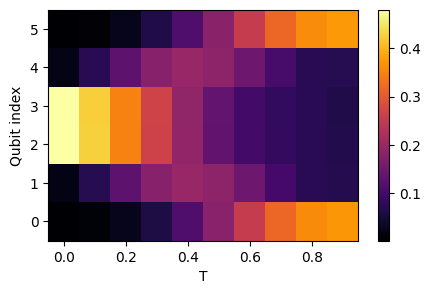

In [228]:
fig = plt.figure(figsize=(10/2,6/2), facecolor='white')
im = plt.pcolormesh([0.1 * i for i in range(nb_timesteps)], np.arange(0,N,1), magnetization.T, cmap='inferno')
fig.colorbar(im)
plt.ylabel('Qubit index')
plt.xlabel('T')

In [229]:
# For gamma = 0.5 case
N = 6

# Generate the unitary
matrix = get_U_HN(2, 0.5, N, 0.1)
gate = UnitaryGate(matrix)

# Create the relevant circuits for paper's Fig 3a
circuits = []
for n_steps in range(1, nb_timesteps+1):
    qc = QuantumCircuit(N+1)
    qc.h(N//2 - 1)
    qc.cx(N//2 - 1, N//2)
    qc.x(range(N//2-1))
    qc.x(range(N//2+1, N))
    
    gate = UnitaryGate(np.linalg.matrix_power(matrix, n_steps))
    qc.append(gate, [i for i in range(N+1)])
    
    qc.measure_all()
    circuits.append(qc)

# Execute measurements for paper's Fig 3a
magnetization=[]
res_list = []
for circ in tqdm(circuits):
    pubs = [(circ)]
    job = sampler.run(pubs, shots=160000)
    results = job.result()
    res = results[0].data.meas.get_counts()

    counts_left = 0
    row = [0 for _ in range(N)]
    for key, value in res.items():
        if key[0] == "0":
            counts_left += value

            for i in range(1, N+1):
                if key[i] == '0':
                    row[i-1] += value
    magnetization.append([x/counts_left for x in row][::-1]) #the output for qiskit is qNqN-1...q1q0

magnetization=np.array(magnetization)

  0%|          | 0/10 [00:00<?, ?it/s]

Text(0.5, 0, 'T')

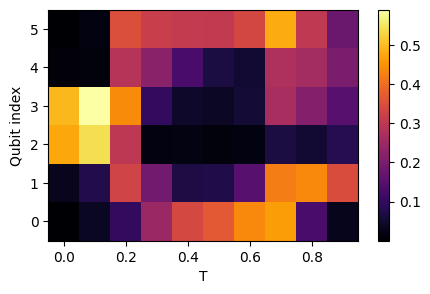

In [230]:
fig = plt.figure(figsize=(10/2,6/2), facecolor='white')
im = plt.pcolormesh([0.1 * i for i in range(nb_timesteps)], np.arange(0,N,1), magnetization.T, cmap='inferno')
fig.colorbar(im)
plt.ylabel('Qubit index')
plt.xlabel('T')

In [315]:
# For gamma = 0.5 case
N = 6

# Generate the unitary
matrix = get_U_HN(2, 0.5, N, 0.1)
gate = UnitaryGate(matrix)

initial_vector = np.zeros((2**(N+1), 1))
initial_vector[2**(N//2)] = 1/np.sqrt(2)
initial_vector[2**(N//2 -1)] = 1/np.sqrt(2)

# Create the relevant circuits for paper's Fig 3a
circuits = []
for n_steps in range(1, nb_timesteps+1):
    qc = QuantumCircuit(N+1)
    
    
    state_vector = np.matmul(np.linalg.matrix_power(matrix, n_steps), initial_vector).T
    qc.initialize(state_vector[0], range(N+1))

    
    qc.measure_all()
    circuits.append(qc)

# Execute measurements for paper's Fig 3a
magnetization=[]
res_list = []
for circ in tqdm(circuits):
    pubs = [(circ)]
    job = sampler.run(pubs, shots=160000)
    results = job.result()
    res = results[0].data.meas.get_counts()

    counts_left = 0
    row = [0 for _ in range(N)]
    for key, value in res.items():
        if key[0] == "0":
            counts_left += value

            for i in range(1, N+1):
                if key[i] == '1':
                    row[i-1] += value
    magnetization.append([x/counts_left for x in row][::-1]) #the output for qiskit is qNqN-1...q1q0

magnetization=np.array(magnetization)

  0%|          | 0/10 [00:00<?, ?it/s]

Text(0.5, 0, 'T')

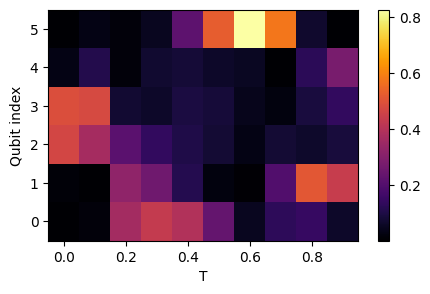

In [316]:
fig = plt.figure(figsize=(10/2,6/2), facecolor='white')
im = plt.pcolormesh([0.1 * i for i in range(nb_timesteps)], np.arange(0,N,1), magnetization.T, cmap='inferno')
fig.colorbar(im)
plt.ylabel('Qubit index')
plt.xlabel('T')